<a href="https://colab.research.google.com/github/AlexandraGl/tensorflow_keras/blob/master/TempField.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image, ImageStat
import math
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from datetime import datetime


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
your_module = drive.CreateFile({'id':'13s9wC54icw1iD1BhDg1W7cMovCIBLK6v'})


In [0]:
your_module.GetContentFile('Intencity_cal.py')

In [0]:
import Intencity_cal as ic

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Lamp brightness temperature 2068.0767138897054
0


In [0]:
Tav_path = "/gdrive/My Drive/HyperLab/Lheating/2018.07.09.laser/011/Tav_t.txt"


In [0]:
time, Tav_f = np.loadtxt(Tav_path, delimiter = '\t', unpack=True)

In [0]:
Tmax_path = '/gdrive/My Drive/HyperLab/Lheating/2018.07.09.laser/011/Tmax_t.txt'

In [0]:
time, Tmax_f = np.loadtxt(Tmax_path, delimiter = '\t', unpack = True)

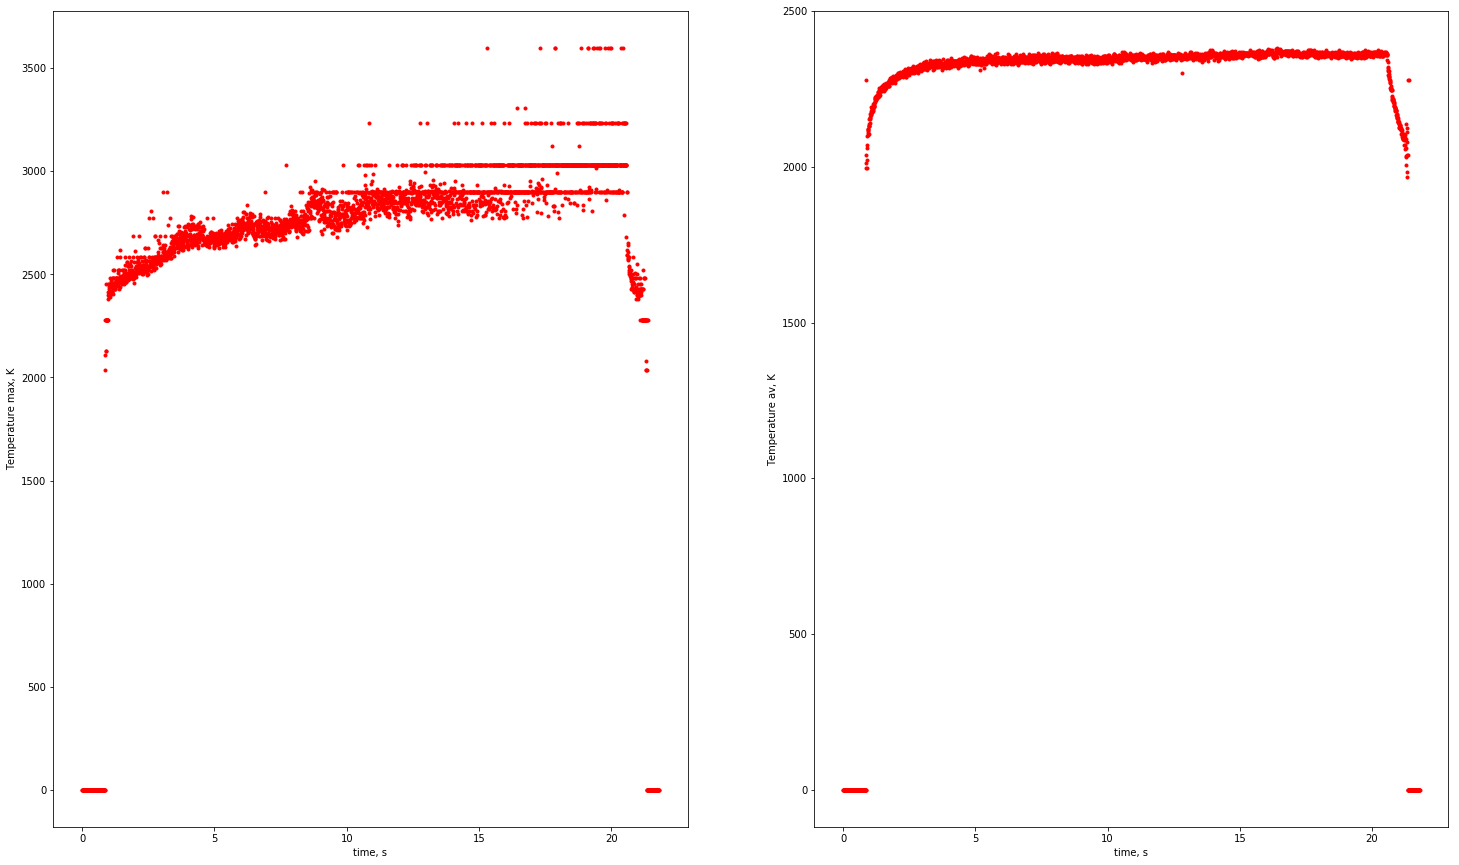

In [0]:
mask1 = time < 16
mask2 = time > 15
mask3 = Tmax_f > 3500
fig = plt.figure(figsize = (25,15))
fig.add_subplot(1, 2, 1)
#plt.plot(time[mask1*mask2*mask3], Tmax_f[mask1*mask2*mask3],'r.')
plt.plot(time, Tmax_f, 'r.')
plt.xlabel('time, s')
plt.ylabel('Temperature max, K')

fig.add_subplot(1, 2, 2)
#plt.plot(time[mask], Tav_f[mask],'r.')
plt.plot(time, Tav_f, 'r.')
plt.xlabel('time, s')
plt.ylabel('Temperature av, K')
plt.show()

In [0]:
t=float(time[mask1*mask2*mask3])
print(t)

15.32


In [0]:
impath_c = "/gdrive/My Drive/HyperLab/Lheating/2018.07.10.laser/020/Acq_A/ImgA"
val_n = 2 #noise value

In [0]:
#stop = time[mask1*mask2*mask3]
stop = 1.0
i = 0
while time[i] < stop:
    i += 1
print(i)

In [0]:
av_r = ic.av_r
A = ic.A
Const = ic.Const

#print(ic.Br_r) 


NameError: ignored

In [0]:
def temp_f(t_s):
  return Br_r - Const*math.exp(A/t_s)

In [0]:
i = 150
t = i/150
tmp = str(i)
impath = impath_c + tmp.zfill(6) + ".tif"
samp_im = Image.open(impath,'r')
np_im = np.array(samp_im) #Convert to numpy, calc mask for noise signal
#r,g,b = np_im[350:-450,400:-450,0], np_im[350:-450,400:-450,1], np_im[350:-450,400:-450,2]
#r,g,b = np_im[400:-530,550:-570,0], np_im[400:-530,550:-570,1], np_im[400:-530,550:-570,2] #for 2018.07.09
r,g,b = np_im[400:-500,650:-400,0], np_im[400:-500,650:-400,1], np_im[400:-500,650:-400,2] #for 2018.07.10
#val_n = 3 #noise value
mask_r = r > val_n
mask_g = g > val_n
mask_b = b > val_n
mask_rgb = mask_r*mask_g*mask_b #mask where all r g and b bands exceed noise value
br_r = r[mask_rgb]/g[mask_rgb]#calc brightness ratio of r and g bands
T_abs = np.zeros(br_r.size)
for k in range(br_r.size):
    Br_r = br_r[k]/av_r
    sol = optimize.root_scalar(temp_f, bracket=[10, 10000], method='brentq')
    T_abs[k] = sol.root
Tmax_f = np.amax(T_abs)
Tmin_f = np.amin(T_abs)
Tav_f = np.average(T_abs)

In [0]:
print(T_abs.shape)

(181,)


In [0]:
Tfield = np.zeros(r.shape)
X = np.array([])
Y = np.array([])

In [0]:
Tfield[mask_rgb] = T_abs

In [0]:
from matplotlib.ticker import MaxNLocator
levels = MaxNLocator(nbins=25).tick_values(50, Tfield.max())

In [0]:
cmap = plt.get_cmap('inferno')


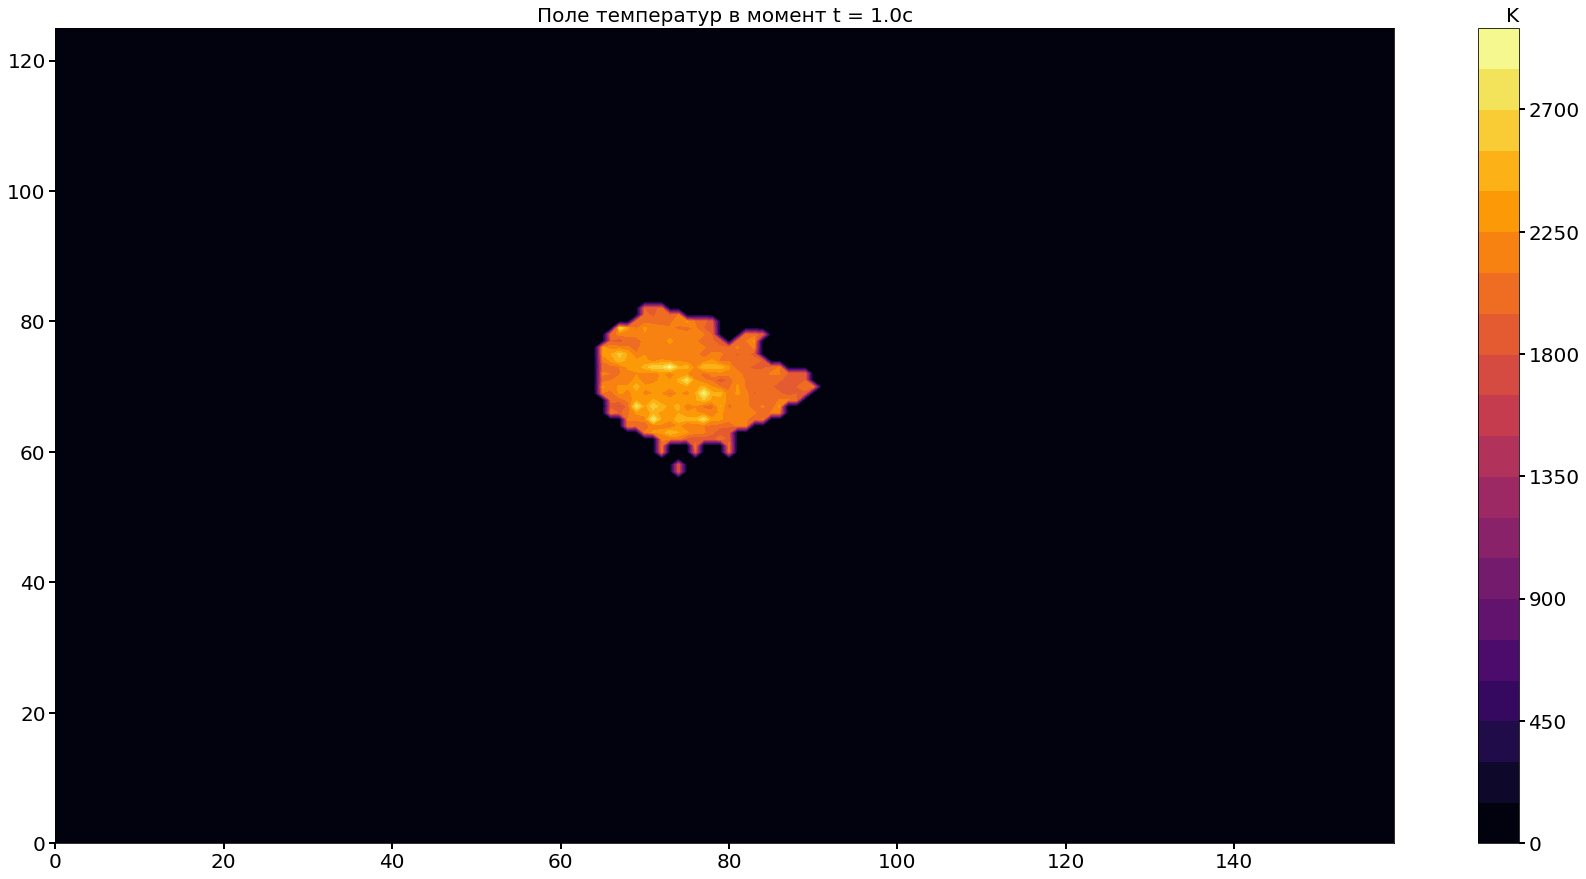

In [0]:
fig = plt.figure(figsize = (30,15))
ax = fig.subplots()
ax.tick_params(direction='out', length=6, width=2, labelsize=20,  colors='k', grid_color='r', grid_alpha=0.5)
cp = ax.contourf(Tfield, cmap=cmap, levels=levels)
cp.cmap.set_under('black')
#cp2 = ax.contour(Tfield, levels=cp.levels[::1], colors = 'b', linewidths=(1.0,))
#cp2 = ax.contour(Tfield, 10, colors = 'r', linewidths=(1.0,))
#ax.clabel(cp2, inline=4, fmt='%4.0f', colors = 'r', fontsize=15)
cbar = plt.colorbar(cp, ax = ax)
cbar.ax.tick_params(direction='out', length=6, width=2, labelsize=20,  colors='k', grid_color='r', grid_alpha=0.5)
cbar.ax.set_title('K',loc = 'right', fontsize = 20)
title = 'Поле температур в момент t = ' + str(t) + 'с'
#title = str(t)
ax.set_title(title, fontsize = 20)

plt.show()

In [0]:
#mpimg.imsave("/gdrive/My Drive/HyperLab/Lheating/2018.07.09.laser/011/Tfield_15.32s", np_im2, vmin=None, vmax=None, cmap=None, format="png", origin=None, dpi=150)
fig.savefig("/gdrive/My Drive/HyperLab/Lheating/2018.07.09.laser/011/Tfield_15,32s", transparent=False, dpi=100)